In [1]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
# get_ipython().run_line_magic('matplotlib', 'inline')
import numpy as np
import pandas as pd
import pickle
import scipy.signal
import patchify
import glob
import cv2
from skimage.exposure import rescale_intensity
import argparse
from sklearn.cluster import KMeans
from itertools import groupby
from skimage import color, data, restoration
import h5py
import random
from tqdm import tqdm
import os
import time

In [2]:
fs = 500000
spec_params={
'nperseg': 512, # default 1024
'noverlap': 256, # default: nperseg / 4
'fs': fs, # raw signal sample rate is 4MHz
'window': 'hamm',
'scaling': 'density', # {'density', 'spectrum'}
'detrend': 'linear', # {'linear', 'constant', False}
'eps': 1e-11}

def specgr (fname,ecen,spec_params,cut_shot):
    ece_data = pickle.load(open(fname,'rb'))
    ece_num = '\\tecef%.2i' % (ecen)
    sig_in = ece_data[ece_num][:np.int_(cut_shot*spec_params['fs'])]
    f, t, Sxx = scipy.signal.spectrogram(sig_in, nperseg=spec_params['nperseg'], noverlap=spec_params['noverlap'],fs=spec_params['fs'], window=spec_params['window'],scaling=spec_params['scaling'], detrend=spec_params['detrend'])
    Sxx = np.log(Sxx + spec_params['eps'])
    Sxx=(Sxx-np.min(Sxx))/(np.max(Sxx)-np.min(Sxx))
    Sxx = Sxx[:-1,:];f=f[:-1]
    return Sxx,f,t


def norm(data):
    mn = data.mean()
    std = data.std()
    return((data-mn)/std)

def rescale(data):
    return (data-data.min())/(data.max()-data.min())

def quantfilt(src,thr=0.9):
    filt = np.quantile(src,thr,axis=0)
    out = np.where(src<filt,0,src)
    return out

def gaussblr(src,filt=(31, 3)):
    src = (rescale(src)*255).astype('uint8')
    out = cv2.GaussianBlur(src,filt,0)
    return rescale(out)

def meansub(src):
    mn = np.mean(src,axis=1)[:,np.newaxis]
    out = np.absolute(src - mn)
    return rescale(out)

In [3]:
data_path = "/scratch/gpfs/aonelson/ml_database/ECE_data/"
flist = glob.glob(data_path+"*.pkl")
fname = '/scratch/gpfs/aonelson/ml_database/ECE_data/ece_146079.pkl'

shotn = fname[fname.rfind('_')+1:fname.rfind('.')]

Sxx = []
for chn in range(40):
    s,f,t = specgr(fname,chn+1,spec_params,2)
    Sxx.append(s)
Sxx = np.dstack(Sxx)


In [4]:
thr= 0.9

out_quant= quantfilt(Sxx,thr)
out_gauss=np.empty(Sxx.shape)
out_mean=np.empty(Sxx.shape)
for i in range(40):
    out_gauss[:,:,i] =  gaussblr(out_quant[:,:,i],(31, 3))
    out_mean[:,:,i] = meansub(out_gauss[:,:,i])


[Text(0, 0.5, 'Freq. (KHz)'), None, Text(0.5, 0, 'ECE Channel')]

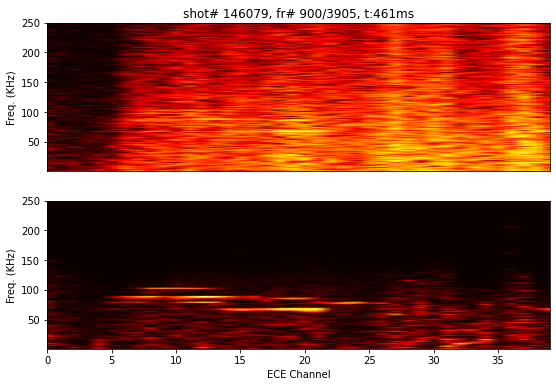

In [5]:
frm = 900

fig = plt.figure(figsize=(9,6))
grd = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
ax=[None] * 2
caption = 'shot# %s, fr# %i/%i, t:%ims' % (shotn, frm, Sxx.shape[1], t[frm]*1000)
ax[0] = fig.add_subplot(grd[0])
ax[0].cla()
ax[0].pcolormesh(range(40),(f/1000)+1,Sxx[:,frm,:],cmap='hot',shading='gouraud')
ax[0].set(ylabel='Freq. (KHz)',yscale='linear',xticks=[],title=caption)
ax[1] = fig.add_subplot(grd[1])
ax[1].cla()
ax[1].pcolormesh(range(40),(f/1000)+1,out_mean[:,frm,:],cmap='hot',shading='gouraud')
ax[1].set(ylabel='Freq. (KHz)',yscale='linear',xlabel='ECE Channel')

# plt.savefig(result_path+shotn+'-'+str(frm)+'.jpg', bbox_inches='tight', dpi=100, frameon='false',facecolor='white')

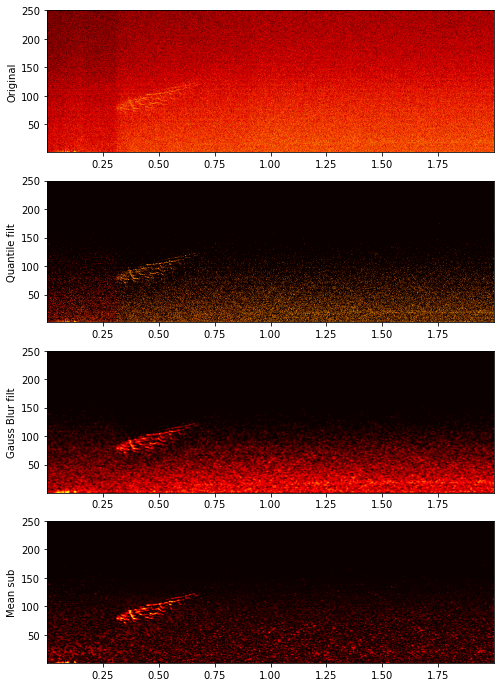

In [6]:
chn = 10

fig = plt.figure(figsize=(8,12))
grd = gridspec.GridSpec(ncols=1, nrows=4, figure=fig)
ax=[None] * 4

ax[0] = fig.add_subplot(grd[0])
ax[0].pcolormesh(t,(f/1000)+1,Sxx[:,:,chn],cmap='hot',shading='gouraud')
_=plt.ylabel('Original')

ax[1] = fig.add_subplot(grd[1])
ax[1].pcolormesh(t,(f/1000)+1,out_quant[:,:,chn],cmap='hot',shading='gouraud')
_=plt.ylabel('Quantile filt')

ax[2] = fig.add_subplot(grd[2])
ax[2].pcolormesh(t,(f/1000)+1,out_gauss[:,:,chn],cmap='hot',shading='gouraud')
_=plt.ylabel('Gauss Blur filt')

ax[3] = fig.add_subplot(grd[3])
ax[3].pcolormesh(t,(f/1000)+1,out_mean[:,:,chn],cmap='hot',shading='gouraud')
_=plt.ylabel('Mean sub')
